In [1]:
import pandas as pd
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp

spark = (SparkSession.builder
         .appName("Warsaw-Weather-Spark")
         .getOrCreate())

BUCKET = "j-27452F4CNYVYM"
PREFIX  = f"s3://{BUCKET}"

read_opts = {
    "header": "true",
    "inferSchema": "true"
}

# Spark DataFrame'y
hourly_sdf  = (spark.read.options(**read_opts)
                         .csv(f"{PREFIX}/warsaw_weather_hourly.csv")
                         .withColumn("time", to_timestamp("time")))

weekly_sdf  = (spark.read.options(**read_opts)
                         .csv(f"{PREFIX}/warsaw_weather_weekly.csv")
                         .withColumn("time", to_timestamp("time")))

monthly_sdf = (spark.read.options(**read_opts)
                         .csv(f"{PREFIX}/warsaw_weather_monthly.csv")
                         .withColumn("time", to_timestamp("time")))

# --- Przemapowanie do Pandas ---
hourly_df  = hourly_sdf.toPandas()
weekly_df  = weekly_sdf.toPandas()
monthly_df = monthly_sdf.toPandas()

# Filtrowanie:
monthly_heatmap_df = monthly_df.sort_values("time").tail(13)
monthly_df = monthly_df.sort_values("time").tail(12)
latest_month = monthly_df["time"].max()
earliest_month = monthly_df["time"].min()
latest_month_heatmap = monthly_heatmap_df["time"].max()
earliest_month_heatmap = monthly_heatmap_df["time"].min()

weekly_full_year_df = weekly_df[
    (weekly_df["time"] >= earliest_month) &
    (weekly_df["time"] <= latest_month)
]
weekly_full_year_heatmap_df = weekly_df[
    (weekly_df["time"] >= earliest_month_heatmap) &
    (weekly_df["time"] <= latest_month_heatmap)
]
weekly_df = weekly_df.sort_values("time").tail(5)

hourly_df = hourly_df[(hourly_df["time"] >= datetime(2025, 6, 24, 0, 0)) &
                      (hourly_df["time"] <= datetime(2025, 6, 24, 23, 59))]



In [2]:
def display_stats(df, freq_label):
    stats = df.describe()[["temperature_2m", "rain", "wind_speed_10m"]].loc[["min", "max", "mean"]]
    stats = stats.rename(index={"mean": "avg"})
    display(stats)
    return stats

print("📅 Monthly Trends:")
monthly_stats = display_stats(monthly_df, "Monthly")

print("\n📅 Weekly Trends:")
weekly_stats = display_stats(weekly_df, "Weekly")

print("\n⏰ Hourly (24 June 2025):")
hourly_stats = display_stats(hourly_df, "Hourly")



📅 Monthly Trends:


,temperature_2m,rain,wind_speed_10m
min,-1.003571,0.009226,8.922024
max,21.632796,0.107796,12.897361
avg,10.450881,0.058669,11.015754



📅 Weekly Trends:


,temperature_2m,rain,wind_speed_10m
min,12.747990,0.029167,9.662500
max,19.137500,0.177381,14.678414
avg,17.112574,0.088736,11.985445



⏰ Hourly (24 June 2025):


,temperature_2m,rain,wind_speed_10m
min,13.3000,0.000000,11.700000
max,20.1000,0.100000,25.500000
avg,17.4625,0.004167,18.554167


Matplotlib is building the font cache; this may take a moment.


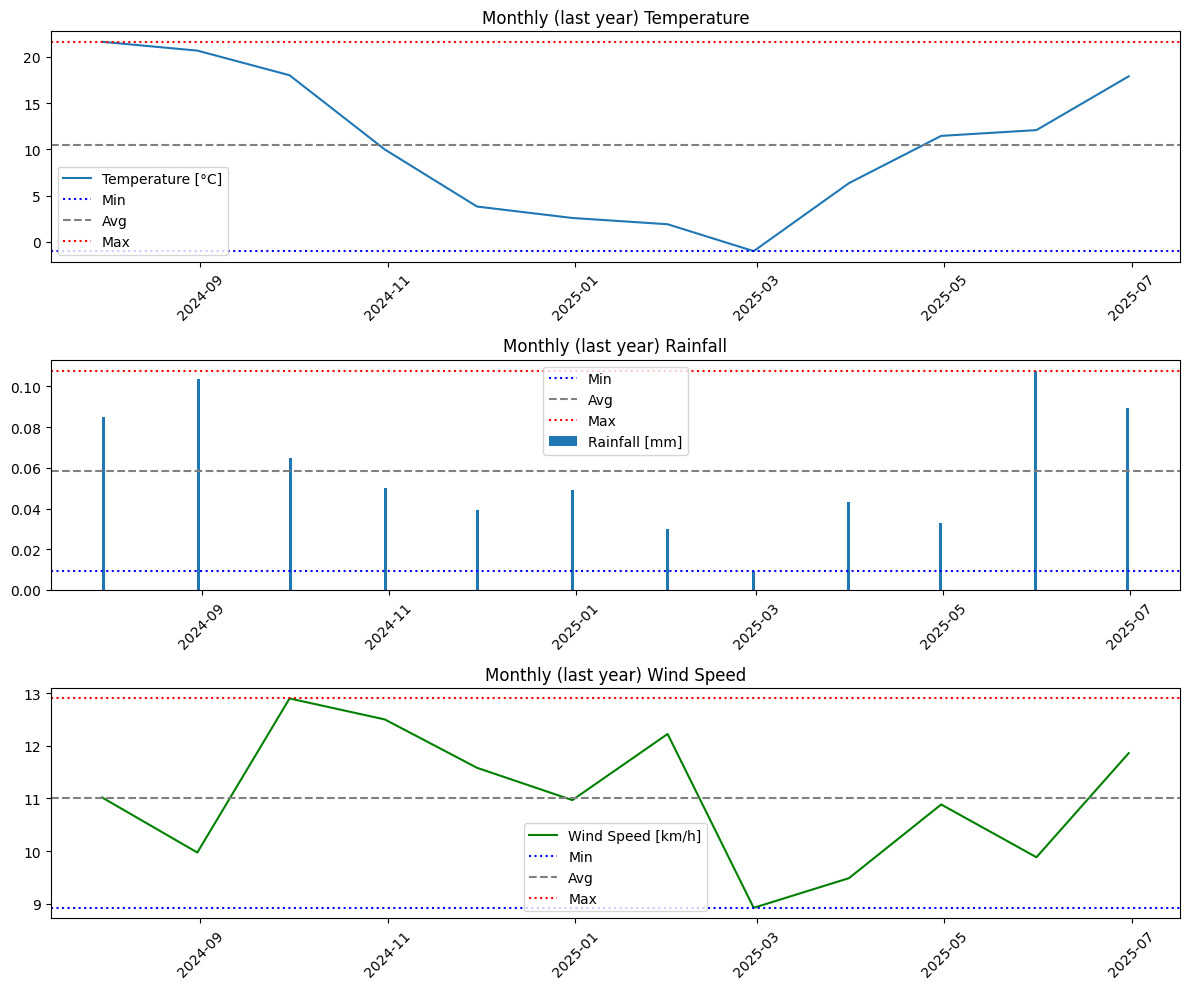

In [3]:
import matplotlib.pyplot as plt

def plot_trends(df, title):
    fig, axs = plt.subplots(3, 1, figsize=(12, 10))  # bez sharex=True

    # Oblicz statystyki
    stats = df[["temperature_2m", "rain", "wind_speed_10m"]].agg(['min', 'mean', 'max'])

    # 1. Temperature
    axs[0].plot(df["time"], df["temperature_2m"], label="Temperature [°C]")
    axs[0].axhline(stats.loc["min", "temperature_2m"], color="blue", linestyle=":", label="Min")
    axs[0].axhline(stats.loc["mean", "temperature_2m"], color="gray", linestyle="--", label="Avg")
    axs[0].axhline(stats.loc["max", "temperature_2m"], color="red", linestyle=":", label="Max")
    axs[0].set_title(f"{title} Temperature")
    axs[0].legend()
    axs[0].tick_params(axis='x', rotation=45)

    if "Monthly" in title:
        bar_width = 1
    elif "Weekly" in title:
        bar_width = 0.1
    elif "Hourly" in title:
        bar_width = 0.005
    else:
        bar_width = 0.05  # domyślna wartość

    # 2. Rain
    axs[1].bar(df["time"], df["rain"], width=bar_width, align='center', label="Rainfall [mm]" )
    axs[1].axhline(stats.loc["min", "rain"], color="blue", linestyle=":", label="Min")
    axs[1].axhline(stats.loc["mean", "rain"], color="gray", linestyle="--", label="Avg")
    axs[1].axhline(stats.loc["max", "rain"], color="red", linestyle=":", label="Max")
    axs[1].set_title(f"{title} Rainfall")
    axs[1].legend()
    axs[1].tick_params(axis='x', rotation=45)

    # 3. Wind Speed
    axs[2].plot(df["time"], df["wind_speed_10m"], label="Wind Speed [km/h]", color='green')
    axs[2].axhline(stats.loc["min", "wind_speed_10m"], color="blue", linestyle=":", label="Min")
    axs[2].axhline(stats.loc["mean", "wind_speed_10m"], color="gray", linestyle="--", label="Avg")
    axs[2].axhline(stats.loc["max", "wind_speed_10m"], color="red", linestyle=":", label="Max")
    axs[2].set_title(f"{title} Wind Speed")
    axs[2].legend()
    axs[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# 🟢 Wywołanie dla przefiltrowanych danych
plot_trends(monthly_df, "Monthly (last year)")




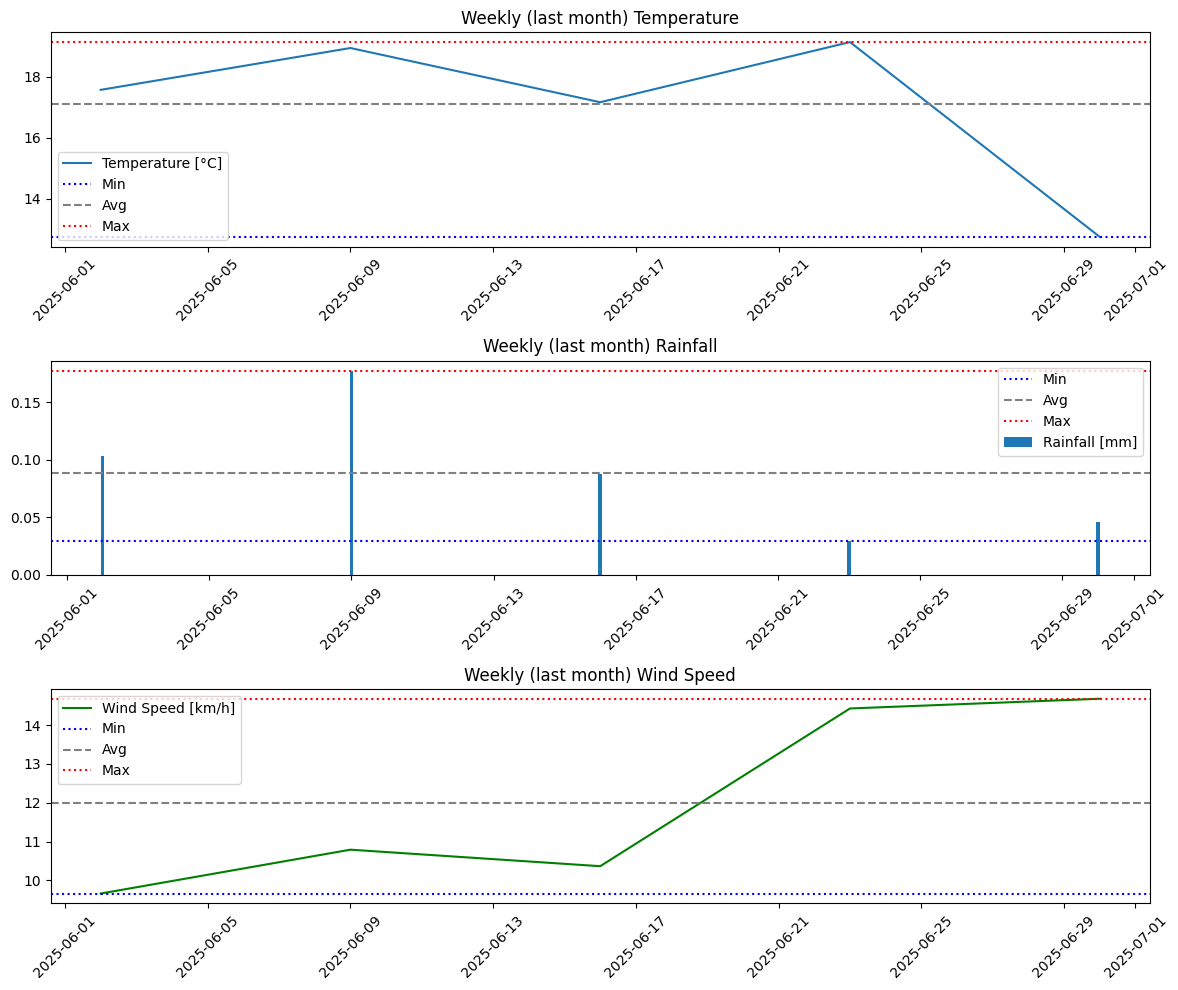

In [4]:
plot_trends(weekly_df, "Weekly (last month)")


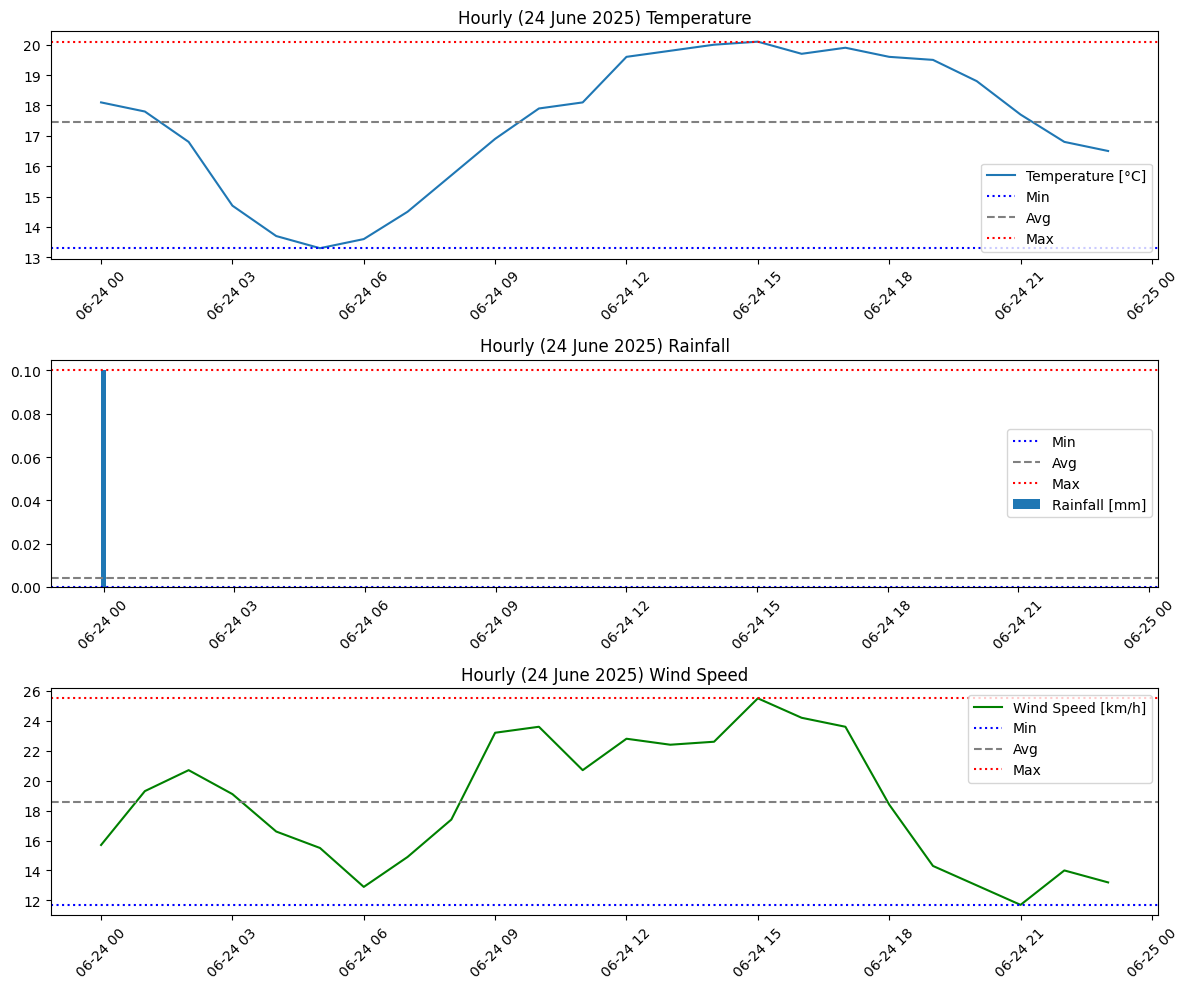

In [5]:
plot_trends(hourly_df, "Hourly (24 June 2025)")

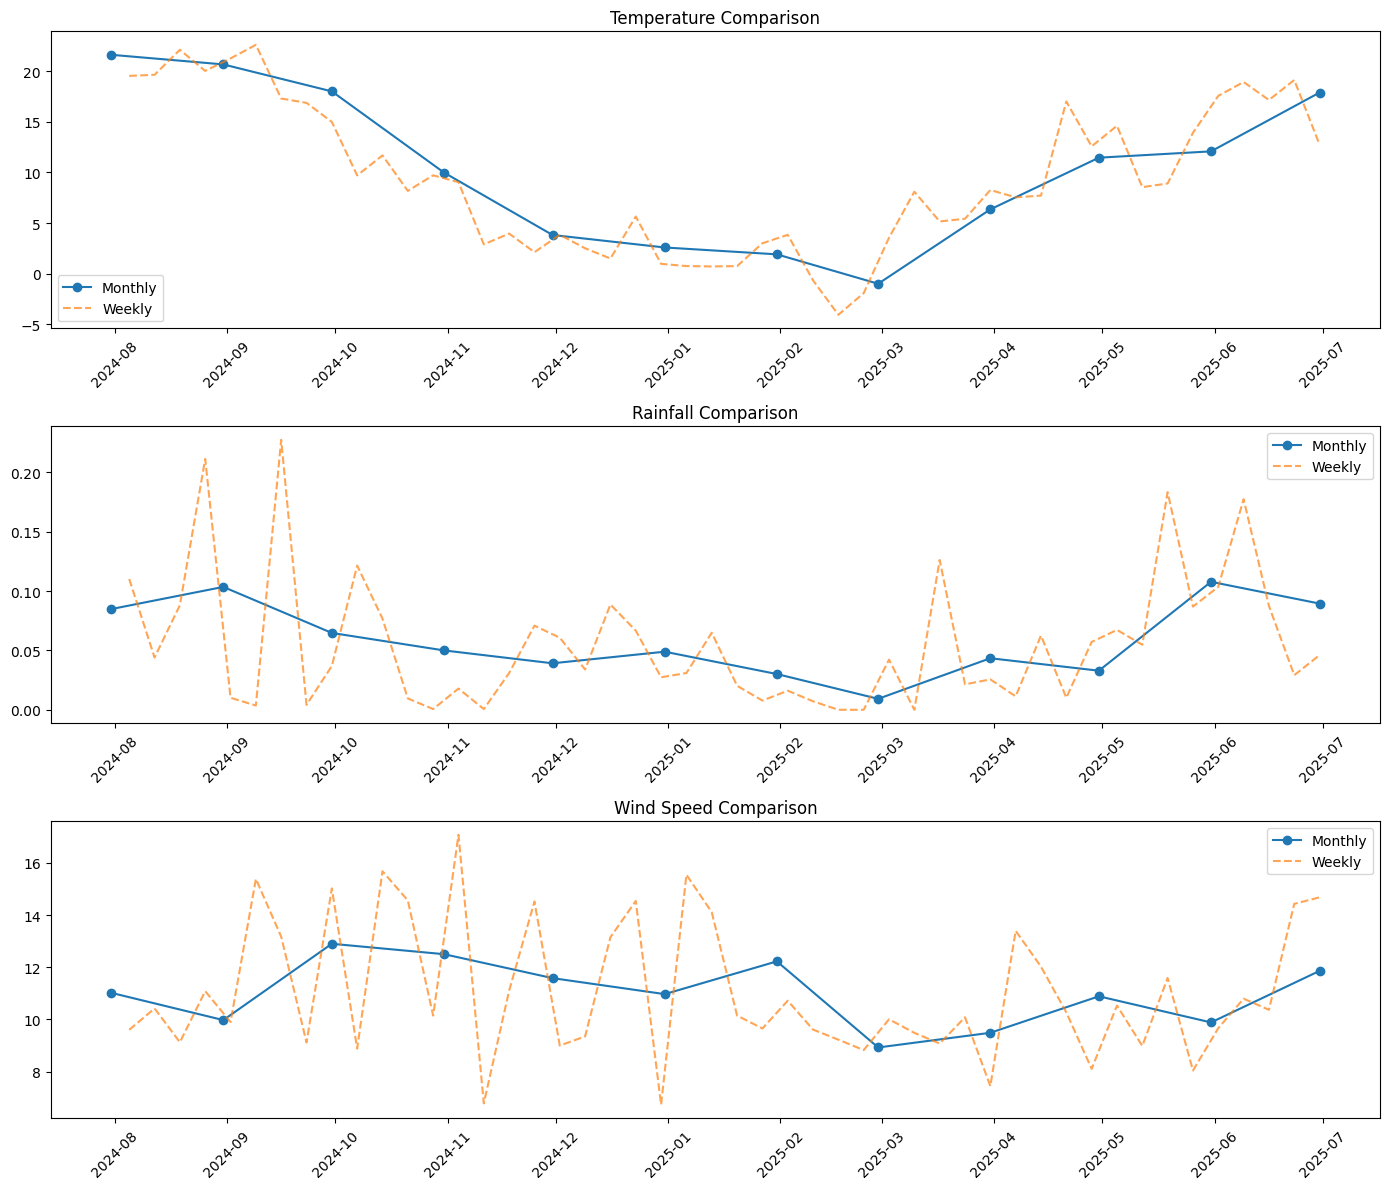

In [6]:
import matplotlib.dates as mdates

def compare_monthly_weekly(monthly_df, weekly_df):
    fig, axs = plt.subplots(3, 1, figsize=(14, 12))

    # 1. Temperature
    axs[0].plot(monthly_df["time"], monthly_df["temperature_2m"], label="Monthly", marker='o')
    axs[0].plot(weekly_df["time"], weekly_df["temperature_2m"], label="Weekly", linestyle='--', alpha=0.7)
    axs[0].set_title("Temperature Comparison")
    axs[0].legend()
    axs[0].tick_params(axis='x', rotation=45)

    # 2. Rain
    axs[1].plot(monthly_df["time"], monthly_df["rain"], label="Monthly", marker='o')
    axs[1].plot(weekly_df["time"], weekly_df["rain"], label="Weekly", linestyle='--', alpha=0.7)
    axs[1].set_title("Rainfall Comparison")
    axs[1].legend()
    axs[1].tick_params(axis='x', rotation=45)

    # 3. Wind Speed
    axs[2].plot(monthly_df["time"], monthly_df["wind_speed_10m"], label="Monthly", marker='o')
    axs[2].plot(weekly_df["time"], weekly_df["wind_speed_10m"], label="Weekly", linestyle='--', alpha=0.7)
    axs[2].set_title("Wind Speed Comparison")
    axs[2].legend()
    axs[2].tick_params(axis='x', rotation=45)

    # Formatowanie daty
    for ax in axs:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())

    plt.tight_layout()
    plt.show()

# 🔄 Wywołanie funkcji porównującej
compare_monthly_weekly(monthly_df, weekly_full_year_df)



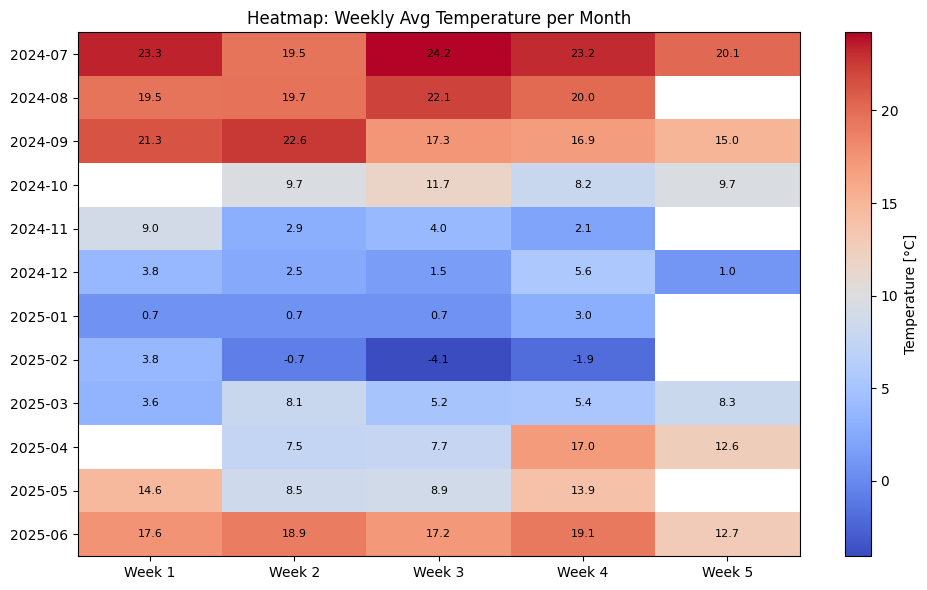

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Przygotowanie kolumn pomocniczych
weekly_full_year_heatmap_df["month"] = weekly_full_year_heatmap_df["time"].dt.strftime("%Y-%m")
weekly_full_year_heatmap_df["week_in_month"] = weekly_full_year_heatmap_df["time"].dt.day // 7 + 1

# Unikalne miesiące i tygodnie
months = weekly_full_year_heatmap_df["month"].unique()
weeks = [1, 2, 3, 4, 5]

# Inicjalizacja macierzy do heatmapy
heatmap = np.full((len(months), len(weeks)), np.nan)

# Wypełnianie danych temperaturowych
for i, month in enumerate(months):
    for j, week in enumerate(weeks):
        val = weekly_full_year_heatmap_df[
            (weekly_full_year_heatmap_df["month"] == month) &
            (weekly_full_year_heatmap_df["week_in_month"] == week)
        ]["temperature_2m"]
        if not val.empty:
            heatmap[i, j] = val.mean()

# Rysowanie heatmapy
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.imshow(heatmap, cmap="coolwarm", aspect="auto")

# Opisy osi
ax.set_xticks(np.arange(len(weeks)))
ax.set_yticks(np.arange(len(months)))
ax.set_xticklabels([f"Week {w}" for w in weeks])
ax.set_yticklabels(months)

# Dodanie wartości do komórek
for i in range(len(months)):
    for j in range(len(weeks)):
        val = heatmap[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.1f}", ha="center", va="center", color="black", fontsize=8)

ax.set_title("Heatmap: Weekly Avg Temperature per Month")
plt.colorbar(c, ax=ax, label="Temperature [°C]")
plt.tight_layout()
plt.show()
